--- COMPILANDO C ---
--- EJECUTANDO C (Resolución: 1000x1000) ---
✅ Cálculo finalizado.
--- GRAFICANDO EN PYTHON ---
✅ Imagen guardada como: fractal_1000x1000.png


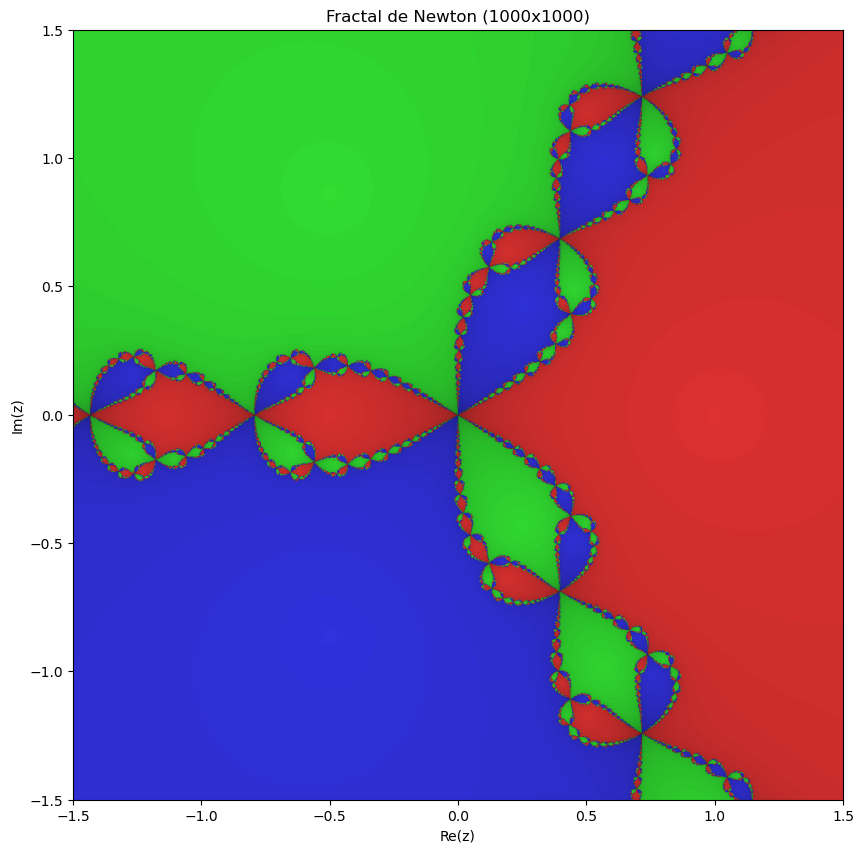

In [ ]:
import sympy as sp
import subprocess
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# configuracion de parametros globales
CONF = {
    "WIDTH": 800,
    "HEIGHT": 800,
    "X_MIN": -2.0,
    "X_MAX": 2.0,
    "Y_MIN": -2.0,
    "Y_MAX": 2.0,
    "MAX_ITER": 50
}

# definicion de la funcion
USER_FUNC_STR = "z**4 + z**3 - 3* z**2 - 1"  
# Otros ejemplos: "z**4 - 1", "z**3 - 2*z + 2"

# crea codigo c necesario
def generate_c_code(func_str):
    print(f"--- ANALIZANDO FUNCIÓN: f(z) = {func_str} ---")
    
    z = sp.symbols('z') # z variable simbolica para sympy
    
    # parsear función, de string a expresion que sympy pueda manejar
    try:
        f_expr = sp.sympify(func_str)
    except:
        print("Error: No se pudo entender la función.")
        sys.exit(1)

    # calcular derivada simbolica automaticamente
    df_expr = sp.diff(f_expr, z)
    print(f"Derivada calculada: f'(z) = {df_expr}")

    # encontrar raices (para pasarlas a C)
    # Convertimos a polinomio para numpy (más robusto numéricamente)
    try:
        poly = sp.Poly(f_expr, z)
        coeffs = poly.all_coeffs() # extrae coeficiente del polinomio
        # calculo de raices, Numpy roots devuelve array de complejos
        roots_np = np.roots(coeffs)
        print(f"Raíces encontradas: {len(roots_np)}")
    except:
        print("La función no es un polinomio simple. El coloreado podría fallar.")
        # Fallback por defecto si no es polinomio
        roots_np = [1+0j, -0.5+0.866j, -0.5-0.866j] 

    # traducir formulas a C
    # Sympy tiene una función 'ccode' que traduce matemáticas a C
    # cpow es la potencia en C, I es imaginario
    f_c = sp.ccode(f_expr).replace('pow', 'cpow') # funcion
    df_c = sp.ccode(df_expr).replace('pow', 'cpow') # derivada

    # generar el array de raices en formato C
    roots_c_str = "{\n"
    for r in roots_np:
        # Escribimos los complejos como a + b * I
        roots_c_str += f"        {r.real} + {r.imag} * I,\n"
    roots_c_str += "    }"

    # PLANTILLA DEL CÓDIGO C
    # Inyectamos f_c, df_c y las raíces en el texto
    c_template = f"""
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <complex.h>

#define MAX_ITER {CONF['MAX_ITER']}
#define TOL 1e-6
#define TOL_SQUARED (TOL * TOL)
#define NUM_ROOTS {len(roots_np)}

// --- CÓDIGO GENERADO POR PYTHON ---
double complex f(double complex z) {{
    return {f_c};
}}

double complex df(double complex z) {{
    return {df_c};
}}

int main(int argc, char *argv[]) {{
    if (argc != 7) return 1;

    int width = atoi(argv[1]);
    int height = atoi(argv[2]);
    double x_min = atof(argv[3]);
    double x_max = atof(argv[4]);
    double y_min = atof(argv[5]);
    double y_max = atof(argv[6]);

    // Raíces inyectadas desde Python
    const double complex roots[NUM_ROOTS] = {roots_c_str};

    FILE *fp = fopen("fractal_data.csv", "w");
    fprintf(fp, "root_idx,iterations\\n");

    for (int y = 0; y < height; y++) {{
        for (int x = 0; x < width; x++) {{
            double re = x_min + (double)x / (width - 1) * (x_max - x_min);
            double im = y_min + (double)y / (height - 1) * (y_max - y_min);
            double complex z = re + im * I;

            int iterations = 0;
            int root_idx = -1;

            for (int k = 0; k < MAX_ITER; k++) {{
                double complex deriv = df(z);
                if (cabs(deriv) < 1e-14) break;

                z = z - f(z) / deriv;
                iterations++;

                int converged = 0;
                for (int r = 0; r < NUM_ROOTS; r++) {{
                    double complex diff = z - roots[r];
                    if (creal(diff)*creal(diff) + cimag(diff)*cimag(diff) < TOL_SQUARED) {{
                        root_idx = r;
                        converged = 1;
                        break;
                    }}
                }}
                if (converged) break;
            }}
            fprintf(fp, "%d,%d\\n", root_idx, iterations);
        }}
    }}
    fclose(fp);
    return 0;
}}
"""
    # escribe el codigo C en el archivo
    with open("fractal_generated.c", "w") as f:
        f.write(c_template)
    print("Archivo 'fractal_generated.c' creado dinámicamente.")

# compilador y ejecucion del calculo
def compile_and_run():
    # compilar
    exe_name = "fractal_gen"
    if os.name == 'nt': exe_name += ".exe"
    
    cmd_compile = ["gcc", "fractal_generated.c", "-o", exe_name, "-lm", "-O3"]
    subprocess.run(cmd_compile, check=True)
    
    # ejecutar
    cmd_run = [
        "./" + exe_name if os.name != 'nt' else exe_name,
        str(CONF["WIDTH"]), str(CONF["HEIGHT"]),
        str(CONF["X_MIN"]), str(CONF["X_MAX"]),
        str(CONF["Y_MIN"]), str(CONF["Y_MAX"])
    ]
    subprocess.run(cmd_run, check=True) # aqui ocurre el calculo del fractal

def plot_fractal():
    print("--- GRAFICANDO ---")
    df = pd.read_csv("fractal_data.csv")
    w, h = CONF["WIDTH"], CONF["HEIGHT"]
    
    roots = df['root_idx'].values.reshape((h, w)) # reestructura lo datos del indice en una matrix height x width
    iters = df['iterations'].values.reshape((h, w)) # reestructura los datos de iteraciones en una amtrix height x width 
    
    # paleta de colores dinamica segun cantidad de raices
    num_roots = roots.max() + 1
    # Usamos un mapa de colores de matplotlib 
    cmap = plt.get_cmap('tab10', num_roots) 
    
    # crear imagen RGB
    img = np.zeros((h, w, 3))
    
    # asignar colores base
    mask_conv = roots >= 0
    for r in range(num_roots):
        r_mask = (roots == r)
        color = cmap(r)[:3] # Tomar RGB del mapa
        img[r_mask] = color
        
    # Aplicar sombras por iteraciones
    brightness = 1.0 - (iters / CONF["MAX_ITER"]) * 0.6
    for c in range(3): img[..., c] *= brightness
    img[~mask_conv] = 0.0

    plt.figure(figsize=(8,8))
    plt.imshow(img, extent=[CONF["X_MIN"], CONF["X_MAX"], CONF["Y_MIN"], CONF["Y_MAX"]], origin='lower')
    plt.title(f"Fractal de Newton: f(z) = {USER_FUNC_STR}")
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.show()

if __name__ == "__main__":
    # 1. Python calcula derivadas y raíces, y escribe el C
    generate_c_code(USER_FUNC_STR)
    
    # 2. Compilar y correr el C generado
    compile_and_run()
    
    # 3. Mostrar resultado
    plot_fractal()